<a href="https://colab.research.google.com/github/Jojocko/NLP-projects-/blob/main/Supply_chain_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

df = pd.read_csv('/content/drive/My Drive/Datasets NLP/dataset_supplychain.csv')

Mounted at /content/drive


In [ ]:
df = df.drop(['client', 'langage', 'reponse'], axis=1)
df.rename(columns={'Sentiment': 'sentiment', 'Commentaire': 'commentaire'}, inplace=True)
df['sentiment'] = df['sentiment'].replace({'__label__POSITIVE': 'positif', '__label__NEGATIVE': 'negatif', '__label__NEUTRAL': 'neutre'})
df['date'] = df['date'].fillna(method="ffill")
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year # pour une visualisation de l'évolution chronologique plus claire

In [ ]:
df_paires = pd.read_csv('/content/drive/My Drive/Datasets NLP/paires_commentaires.csv')

In [ ]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('french'))

jugement = {'très', 'extrêmement', 'particulièrement', 'exceptionnellement','tout à fait', 'absolument', 'complètement', 'entièrement', 'parfaitement', 'profondément', 'hautement', 'tout', 'plutôt', 'assez', 'bien', 'bon','vraiment', 'totalement', 'énormément', 'peu', 'moins'}
satisfaction = {'satisfait', 'content', 'heureux', 'ravi', 'enchanté', 'comblé', 'agréable', 'plaisant', 'positif', 'excellent', 'remarquable', 'exceptionnel', 'superbe', 'admirable', 'réjoui', 'gratifiant', 'récompensant', 'conquis', 'impressionné', 'élogieux'}
insatisfaction = {'insatisfait', 'mécontent', 'déçu', 'frustré', 'contrarié', 'désappointé', 'inacceptable', 'problématique', 'inadmissible', 'déplorable', 'lamentable', 'irrité', 'en colère', 'révolté', 'amère', 'négatif', 'critique', 'malheureux', 'peu convaincu', 'regrettable'}
company = {'Fnac', 'fnac', 'Amazon', 'amazon', 'CDiscount', 'cdiscount'}

stop_words.update(jugement, satisfaction, insatisfaction, company)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Traitement des données

import re
import unicodedata
from nltk.tokenize import word_tokenize

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Z?.!]+", " ", w)
    w = re.sub(r'\b\w{0,2}\b', '', w)

    mots = word_tokenize(w.strip())
    mots = [mot for mot in mots if mot not in stop_words]
    return ' '.join(mots).strip()

df.cleaned_lemma = df.cleaned_lemma.apply(lambda x :preprocess_sentence(x))

In [ ]:
# Prétraitement ET lemmatisation pour df_paires

from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag

nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

lemmatizer = WordNetLemmatizer()

def lemmatisation(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def preprocess_and_lemmatize(sentence):
    sentence = unicode_to_ascii(sentence.lower().strip())
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!]+", " ", sentence)
    sentence = re.sub(r'\b\w{0,2}\b', '', sentence)

    mots = word_tokenize(sentence.strip())
    mots_tagged = pos_tag(mots)

    lemmatizer = WordNetLemmatizer()
    mots_lemmatises = [lemmatizer.lemmatize(mot, lemmatisation(tag)) for mot, tag in mots_tagged]
    mots_lemmatises = [mot for mot in mots_lemmatises if mot not in stop_words]

    return ' '.join(mots_lemmatises).strip()

df_paires['Commentaire A'] = df_paires['Commentaire A'].apply(preprocess_and_lemmatize)
df_paires['Commentaire B'] = df_paires['Commentaire B'].apply(preprocess_and_lemmatize)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Calcul de la distance sémantique des paires de comm (100 paires)

!pip install sentence-transformers
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

import numpy as np

model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2') # spécialisé dans la génération d'embeddings + fr / sur Huggningface: récemment updtaté, le + téléchargé, le + liké

embeddings_A = model.encode(df_paires['Commentaire A'].tolist(), convert_to_tensor=True) # conversion en tensor 2D pour calculer la cosine similarity
embeddings_B = model.encode(df_paires['Commentaire B'].tolist(), convert_to_tensor=True)

embeddings_A_cpu = [embedding.cpu().numpy() for embedding in embeddings_A]
embeddings_B_cpu = [embedding.cpu().numpy() for embedding in embeddings_B]

similarities = [cosine_similarity([embeddings_A_cpu[i]], [embeddings_B_cpu[i]])[0][0] for i in range(len(embeddings_A_cpu))]

df_paires['Distance sémantique'] = similarities

df_paires.head()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.1/163.1 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 54.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 60.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 91.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.12k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

,Commentaire A,Commentaire B,Distance sémantique
0,site tellement lent frustrant .,mal trouver produits voulais moteur recherche ...,0.512581
1,site tellement lent frustrant .,site plante juste moment finalisais commande .,0.299672
2,site tellement lent frustrant .,interface utilisateur intuitive perds temp .,0.437125
3,site tellement lent frustrant .,site pa adapte mobile impossible commander dep...,0.208907
4,mal trouver produits voulais moteur recherche ...,site plante juste moment finalisais commande .,0.171799


In [ ]:
# Finetuning du transformer

from sentence_transformers import InputExample, losses # encapsule une paire d'entrées textuelles et, éventuellement, une étiquette (label) associée à cette paire.
from torch.utils.data import DataLoader # encapsule des données (paires + distances sémantiques) +  batching, mélange des données

paires = [InputExample(texts=[row['Commentaire A'], row['Commentaire B']], label=float(row['Distance sémantique'])) for index, row in df_paires.iterrows()]

train_set = DataLoader(paires, shuffle=True, batch_size=200)

train_loss = losses.CosineSimilarityLoss(model=model)

model.fit(train_objectives=[(train_set, train_loss)], epochs=10, warmup_steps=100) # warmup = augmentation du learning_rate pour stabilier l'entraînement au début



Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

In [27]:
# Clustering

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances_argmin_min

embeddings_negatif = model.encode(df[df['sentiment'] == 'negatif']['cleaned_lemma'].tolist(), show_progress_bar=True)

# normalisation
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings_negatif)

kmeans = KMeans(n_clusters=12, random_state=42)
clusters = kmeans.fit_predict(embeddings_scaled)



Batches:   0%|          | 0/868 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [29]:
df_negatif = df[df['sentiment'] == 'negatif'].copy()
df_negatif = df_negatif.reset_index(drop=True)
df_negatif['cluster'] = clusters

# afficher 5 commentaires pour chaque cluster pour vérifier la qualité des clusters
for i in range(12):
    print(f"Cluster {i}:")
    commentaires_cluster = df_negatif[df_negatif['cluster'] == i]['cleaned_lemma']
    for commentaire in commentaires_cluster.head(5):
        print(commentaire)
    print("---------\n")

Cluster 0:
politique pire contrairement site marchand . montr defectueux rendre jour remboursement methode voleur voyou telephone incompetent version jour retouramazon fuir dernier fois commande concurrence professionnel
telephone rien double prelevement vouloir rien entendre vouloir rembourser etre satisfaire . . . terminer prime commande rien
raison echapper retrouver activer protection double essayer revenir fois envoyer lien telephone vieux truc clapet vouloir acheter smartphone coince numero telephone commencer connecter sonner service client laisse desirer
bonjour venir amazone telephone achat difference prix veule rien savoir . occuper client commande regulierement jour confiance amazone regler aucun probleme client plaindre foute recommander site
commander telephone portable voler telephone assurer telephone necessaire facture appareil contenir numero imei appeler ecrire reprise incapable faire necessaire telephone echange apple cas panne assurer heureusement lire petit ligne a

In [31]:
# attitrer les clusters et afficher les thématisations

themes = {
    0: 'Appareils technologiques défectueux',
    1: 'Problèmes financiers (abonnements, prélèvements)',
    2: 'Problèmes de garantie',
    3: 'Transactions et livraisons contestées',
    4: 'Expériences de fraude et remboursement',
    5: 'Livraison chaotique',
    6: 'Problèmes de suivi et de retards',
    7: 'Gestion client et attentes déçues',
    8: 'Problèmes avec les transporteurs',
    9: 'Problèmes de qualité-prix',
    10: 'Difficultés de retours',
    11: 'Service client et politique discutables'
}

df_negatif['themes'] = df_negatif['cluster'].map(themes)

pd.set_option('display.max_colwidth', 500)
df_negatif.head(20)



,commentaire,star,date,source,company,cleaned_words,cleaned_lemma,sentiment,year,cluster,themes
0,"Colis commandé mardi 28 fevrier 23 , livraison le jeudi 02 mars 23 produit non recu au 7 mars 23Au prix du colis, amazon des incapables et chronopost pareilService client qui veule que je patiente une journée de plusLe colis est introuvable et meme chronopost renvoie la balle a amazonAmazon veut pas me renvoyé un autre article alors que ca fait une semaine que j'attend ce colis",1,2023-03-07,TrustPilot,Amazon,colis commandé mardi fevrier livraison jeudi mars produit non recu mars 23au prix colis amazon incapables chronopost pareilservice client veule patiente journée plusle colis introuvable chronopost renvoie balle amazonamazon veut renvoyé article ca semaine attend colis,colis commander mardi fevrier livraison jeudi mars produit non recu mars prix colis incapable chronopost pareilservic client veule patient journee plusle colis introuvable chronopost renvoyer balle amazonamazon vouloir renvoyer article semaine attendre colis,negatif,2023,8,Problèmes avec les transporteurs
1,Amazon avec sa politique de retour est la pire que j ai vu contrairement a d autre site marchand.Montre défectueuse rendu il y a 10 jours et toujours pas de remboursement ce sont des méthodes de voleurs et de voyous et au téléphone il n y a que des incompétents et personne n a la même version de jours de retourAmazon c est a fuir dernière fois que je commande chez eux la concurrence est plus professionnelle.,1,2023-03-07,TrustPilot,Amazon,amazon politique pire contrairement site marchand.montre défectueuse rendu jours remboursement méthodes voleurs voyous téléphone incompétents version jours retouramazon fuir dernière fois commande concurrence professionnelle,politique pire contrairement site marchand . montr defectueux rendre jour remboursement methode voleur voyou telephone incompetent version jour retouramazon fuir dernier fois commande concurrence professionnel,negatif,2023,0,Appareils technologiques défectueux
2,"Nul, preleve une commande que je n'ai jamais reçu et le service client laisse des blancs jusqu'à ce qu'on raccroche et ça sur plusieurs appel. Donc amazone ma volé Dernière commande pour moi passé chez eux, ça m'apprendras à vouloir acheter chez les americains",1,2023-03-07,TrustPilot,Amazon,preleve commande jamais reçu service client laisse blancs jusqu' raccroche appel amazone volé dernière commande passé apprendras vouloir acheter americains,prelev commande jamais recevoir service client laisse blanc jusque raccrocher appel amazone voler dernier commande passer apprendre vouloir acheter americain,negatif,2023,3,Transactions et livraisons contestées
3,Colis soit disant livré mais jamais reçu donc perdu non remboursé et falsification du bon de livraison soit disant signé par mes soins (Signature en majuscule) MDR je ne signe jamais de documents en majuscule ils moquent de leurs clients je vais résilier mon aboment Amazon Prime et en finir avec eux,1,2023-03-06,TrustPilot,Amazon,colis disant livré jamais reçu perdu non remboursé falsification bon livraison disant signé soins signature majuscule mdr signe jamais documents majuscule moquent clients résilier aboment amazon prime finir,colis dire livrer jamais recevoir perdre non rembourser falsification livraison dire signer soin signature majuscule mdr signe jamais document majuscule moquer client resilier aboment prime finir,negatif,2023,4,Expériences de fraude et remboursement
4,"D'habitude, je jure par Amazon. J'ai aussi un compte Business et j'ai Prime depuis presque son lancement. Mais, j'ai acheté des enceintes bluetooth et alors qu'ils étaient toujours sous garantie j'ai fait la demande de remplacement parce ce qu'ils saturées et celle de droite et très faible par rapport de celle de gauche. Mais, ils étaient en rupture de stock. Amazon m'a dit qu'il les remplacerai lorsque qu'ils y arriver. Alors, j'ai patienté. Maintenant hors garantie, Amazon ne répond même ...",1,2023-03-06,TrustPilot,

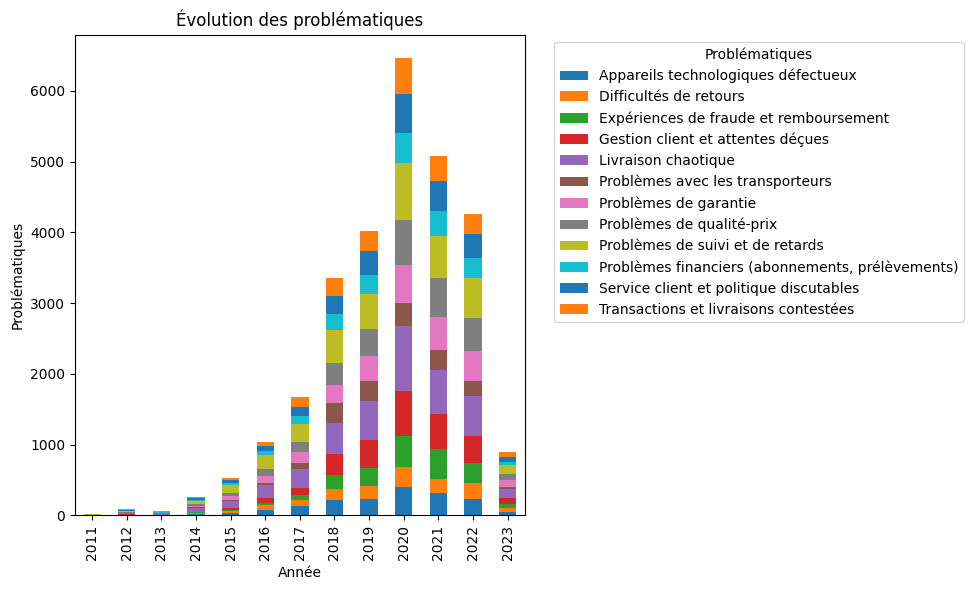

In [32]:
import matplotlib.pyplot as plt

themes_evo = df_negatif.groupby(['year', 'themes']).size().unstack(fill_value=0)

themes_evo.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Évolution des problématiques')
plt.xlabel('Année')
plt.ylabel('Problématiques')
plt.legend(title='Problématiques', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



In [33]:
themes_company = df_negatif.groupby(['company', 'themes']).size().unstack(fill_value=0)

print(themes_company)

themes     Appareils technologiques défectueux  Difficultés de retours  \
company                                                                  
Amazon                                     240                     258   
CDiscount                                  948                     770   
Fnac                                       534                     275   

themes     Expériences de fraude et remboursement  \
company                                             
Amazon                                        311   
CDiscount                                    1278   
Fnac                                          212   

themes     Gestion client et attentes déçues  Livraison chaotique  \
company                                                             
Amazon                                   672                  942   
CDiscount                               1502                 2128   
Fnac                                     324                  775   

themes     Problè